## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Chem.Lipinski as l
import rdkit.Chem.Fragments as f
from rdkit.Chem import Descriptors
import rdkit.Chem.rdMolDescriptors as d

from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

## Extract features from SMILES

In [2]:
def binaryToInt(list):
  return int("".join(str(i) for i in list),2)

def aromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  return np.sum([1 if i == True else 0 for i in aromatic_atoms])

# Append all feature values to a list
def getFeatureValsForM(m):
  features = []
  features.append(m.GetNumAtoms())
  features.append(d.CalcExactMolWt(m))
  features.append(f.fr_Al_COO(m))
  features.append(l.HeavyAtomCount(m))
  features.append(Descriptors.MolLogP(m))
  features.append(Descriptors.MolWt(m))
  features.append(Descriptors.NumRotatableBonds(m))
  features.append(aromaticAtoms(m))
  features.append(aromaticAtoms(m)/Descriptors.HeavyAtomCount(m))
  fp = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=124)
  features.append(binaryToInt(fp))
  return features

# Extract features and add it to DF
def extractFeatures(raw_data):
  data = []
  for smile in raw_data['SMILES']:
    m = Chem.MolFromSmiles(smile)
    feature_vals = getFeatureValsForM(m)
    columns = ['x' + str(i + 1) for i in range(len(feature_vals))]
    data.append(dict(zip(columns, feature_vals)))
  return pd.DataFrame(data)

def plotROCAUC(model, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
  model.fit(X_train, y_train)
  probs = model.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  print('AUC score on train/test split: ' + str(roc_auc))

def testModel(model, X, y):
  strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  score = cross_val_score(model, X, y, cv=strat_k_fold, scoring='roc_auc')
  print(str(score) + ' Average AUC: ' + str(round(np.mean(score), 4)) + ', STD: ' + str(round(np.std(score), 4)))
  plotROCAUC(model, X, y)
  
def tuneModel(model, params_grid, X, y):
  print('Vanilla model')
  testModel(model, X, y)

  strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  grid_search = GridSearchCV(model, param_grid=params_grid, cv=strat_k_fold, scoring='roc_auc')
  grid_search.fit(X, y)
  best_params = grid_search.best_params_
  model.set_params(**best_params)
  
  print('Tuned model with params: ' + str(best_params))
  testModel(model, X, y)


## Read the splitted training data (new_training_smiles.csv)

In [3]:
raw_data = pd.read_csv('new_training_smiles.csv')
raw_data.drop('Unnamed: 0', axis=1, inplace=True)
display(raw_data)

,SMILES,ACTIVE
0,C=C(C)c1cccc(C(C)(C)NC(=O)Nc2cc(C)ccc2OC)c1,0.0
1,CCCN(CCC)C(=O)CC(c1ccccc1)c1ccc(C)cc1O,0.0
2,O=C(CC1NCCNC1=O)Nc1ccccc1,0.0
3,COc1ccccc1-n1cnc2cc(NC(=O)c3ccco3)ccc21,0.0
4,COc1c(CO)cc(CO)cc(CO)c1=O,0.0
...,...,...
134417,C/C(CC(=O)N(C(C)C)C(C)C)=N\NC(=O)COc1ccc(Br)cc1Br,0.0
134418,COc1cc(C(=O)Oc2cccc(C)c2)cc(OC)c1OC,0.0
134419,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1ccccc1,0.0
134420,CC(=O)Nc1cc2c(cc1C(=O)C(C)C)OCCO2,0.0


## Transform data (extract features)

In [4]:
y = [int(label) for label in raw_data['ACTIVE'].values]
raw_data.drop(['ACTIVE'], axis=1, inplace=True)
X = extractFeatures(raw_data)
display(X)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,25,338.199428,0,25,5.09352,338.451,5,12,0.480000,5671210215184166703700378702203336722
1,25,339.219829,0,25,4.87122,339.479,8,12,0.480000,8328916130681602758361976505456021571
2,17,233.116427,0,17,0.10320,233.271,3,6,0.352941,427147556156468491310640550472079366
3,25,333.111341,0,25,3.87940,333.347,4,20,0.800000,523695094110335032410745669696142338
4,16,226.084124,0,16,-0.46770,226.228,4,7,0.437500,21357387526891337304840442166116352
...,...,...,...,...,...,...,...,...,...,...
134417,26,489.026266,0,26,4.11800,491.224,8,6,0.230769,5774448780169953324456184779900983298
134418,22,302.115424,0,22,3.24002,302.326,5,12,0.545455,1682720011216148433928110003258920962
134419,23,349.007864,0,23,2.59630,349.389,3,15,0.652174,3048346208439277882278404635312115722
134420,19,263.115758,0,19,2.25490,263.293,3,6,0.315789,5743091227781309622800876834866108448


## Investigate the correlation of the features

,x1,x2,x3,x4,x5,x6,x7,x8,x9
x1,1.000000,0.962791,-0.031055,0.999994,0.349310,0.962062,0.597099,0.505000,-0.003441
x2,0.962791,1.000000,-0.024988,0.962796,0.343355,0.999993,0.602143,0.448709,-0.043969
x3,-0.031055,-0.024988,1.000000,-0.031052,-0.119249,-0.025097,0.094073,-0.150762,-0.154091
x4,0.999994,0.962796,-0.031052,1.000000,0.349288,0.962067,0.597111,0.504998,-0.003447
x5,0.349310,0.343355,-0.119249,0.349288,1.000000,0.344040,0.138009,0.514625,0.368209
x6,0.962062,0.999993,-0.025097,0.962067,0.344040,1.000000,0.601604,0.448572,-0.043692
x7,0.597099,0.602143,0.094073,0.597111,0.138009,0.601604,1.000000,0.174146,-0.150550
x8,0.505000,0.448709,-0.150762,0.504998,0.514625,0.448572,0.174146,1.000000,0.827332
x9,-0.003441,-0.043969,-0.154091,-0.003447,0.368209,-0.043692,-0.150550,0.827332,1.000000


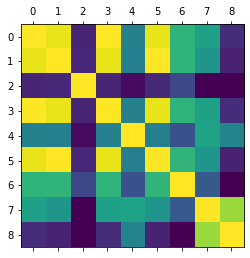

In [8]:
display(X.corr())
plt.matshow(X.corr())
plt.show()

## Conclusions of investigation of correlation of features
x1 and x4 are extremely correlated <br />
x2 and x6 are extremely correlated <br />
x1 and x2, x6 are highly correlated <br />
**Conclusion: Drop x1 and x2**

In [9]:
X.drop(['x1', 'x2'], axis=1, inplace=True)

,x3,x4,x5,x6,x7,x8,x9,x10
0,0,25,5.09352,338.451,5,12,0.480000,5671210215184166703700378702203336722
1,0,25,4.87122,339.479,8,12,0.480000,8328916130681602758361976505456021571
2,0,17,0.10320,233.271,3,6,0.352941,427147556156468491310640550472079366
3,0,25,3.87940,333.347,4,20,0.800000,523695094110335032410745669696142338
4,0,16,-0.46770,226.228,4,7,0.437500,21357387526891337304840442166116352
...,...,...,...,...,...,...,...,...
134417,0,26,4.11800,491.224,8,6,0.230769,5774448780169953324456184779900983298
134418,0,22,3.24002,302.326,5,12,0.545455,1682720011216148433928110003258920962
134419,0,23,2.59630,349.389,3,15,0.652174,3048346208439277882278404635312115722
134420,0,19,2.25490,263.293,3,6,0.315789,5743091227781309622800876834866108448


,x3,x4,x5,x6,x7,x8,x9
x3,1.000000,-0.031052,-0.119249,-0.025097,0.094073,-0.150762,-0.154091
x4,-0.031052,1.000000,0.349288,0.962067,0.597111,0.504998,-0.003447
x5,-0.119249,0.349288,1.000000,0.344040,0.138009,0.514625,0.368209
x6,-0.025097,0.962067,0.344040,1.000000,0.601604,0.448572,-0.043692
x7,0.094073,0.597111,0.138009,0.601604,1.000000,0.174146,-0.150550
x8,-0.150762,0.504998,0.514625,0.448572,0.174146,1.000000,0.827332
x9,-0.154091,-0.003447,0.368209,-0.043692,-0.150550,0.827332,1.000000


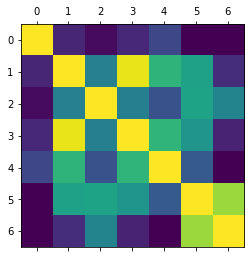

In [10]:
display(X)
display(X.corr())
plt.matshow(X.corr())
plt.show()

## Look at feature importance

[0.00079781 0.04005182 0.249196   0.24355287 0.06949247 0.03435421
 0.05133029 0.31122454]


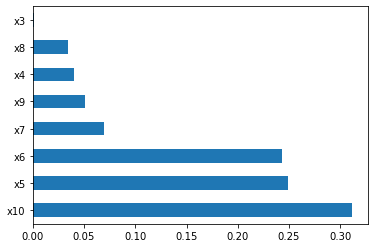

In [11]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

**Conclusions: drop x3**

In [17]:
X.drop(['x3'], axis=1, inplace=True)

## Test vanilla models

### Bernoulli Naive Bayes classifier

C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 32 bins
[0.76380568 0.82088202 0.7989465  0.78358581 0.81253436 0.7756149
 0.84482244 0.77536949 0.7964551  0.7496741 ] Average AUC: 0.7922, STD: 0.027


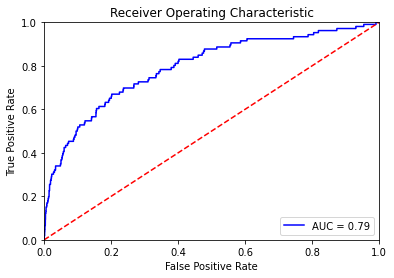

AUC score on train/test split: 0.7938499014362153


In [30]:
# --- Discretization 32 bins is best! ---

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 2 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 4 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 8 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 16 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=32, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 32 bins')
testModel(BernoulliNB(), X_cop, y)

Bernoulli Naive Bayes classifier best preprocessing = Discretization 16 bins (Average AUC: 0.81, STD: 0.0274, AUC score on train/test split: 0.801)

### Gaussian Naive Bayes classifier

StandardScaler
[0.77389451 0.82817988 0.77176295 0.78054862 0.82401365 0.75405319
 0.84315954 0.7778334  0.78492673 0.76080785] Average AUC: 0.7899, STD: 0.0291


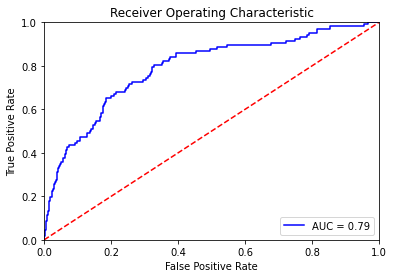

AUC score on train/test split: 0.7895525204167839


In [27]:
X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(GaussianNB(), X_cop, y)

# --- Standard and MinMax scaler yields the same result! ---

# X_cop = X.copy()
# sc = MinMaxScaler()
# X_cop = sc.fit_transform(X_cop)
# print('MinMaxScaler')
# testModel(GaussianNB(), X_cop, y)

# --- This crashes! ---

# X_cop = X.copy()
# kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
# X_cop = kbd.fit_transform(X_cop)
# print('Discretization')
# testModel(GaussianNB(), X_cop, y)

Gaussian Naive Bayes classifier best preprocessing = standard or minmax scaler (Average AUC: 0.7969, STD: 0.0246, AUC score on train/test split: 0.784)

### Multinomial Naive Bayes classifier

C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 32 bins
[0.76380568 0.82088202 0.7989465  0.78358581 0.81253436 0.7756149
 0.84482244 0.77536949 0.7964551  0.7496741 ] Average AUC: 0.7922, STD: 0.027


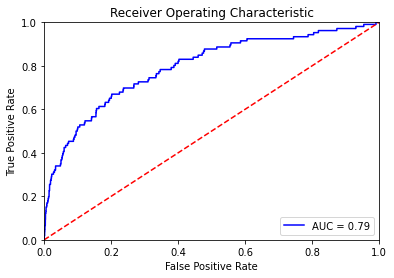

AUC score on train/test split: 0.7938499014362153


In [25]:
# --- This crashes! ---

# X_cop = X.copy()
# sc = StandardScaler()
# X_cop = sc.fit_transform(X_cop)
# print('StandardScaler')
# testModel(MultinomialNB(), X_cop, y)

# --- Discretization 32 bins is best! ---

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 2 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 4 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 8 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 16 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=32, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 32 bins')
testModel(MultinomialNB(), X_cop, y)

Multinomial Naive Bayes classifier best preprocessing = Discretization 16 bins (Average AUC: 0.81, STD: 0.0274, AUC score on train/test split: 0.801)

### Decision Tree classifier

[0.51117921 0.52430197 0.52437607 0.52459988 0.53775778 0.537425
 0.55102758 0.53817105 0.53783533 0.49873172] Average AUC: 0.5285, STD: 0.0145


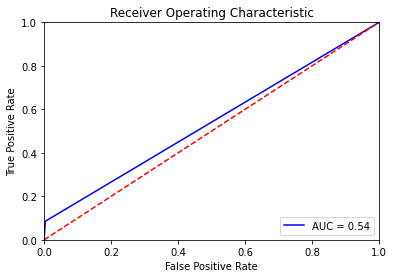

AUC score on train/test split: 0.5410064770487187


In [23]:
# TODO: Investigate if we need to change data to fit model
testModel(DecisionTreeClassifier(), X, y)

### Random Forest classifier

[0.66570733 0.76459859 0.72718866 0.69450989 0.77480308 0.63178902
 0.78888666 0.81545866 0.74698146 0.71408181] Average AUC: 0.7324, STD: 0.0543


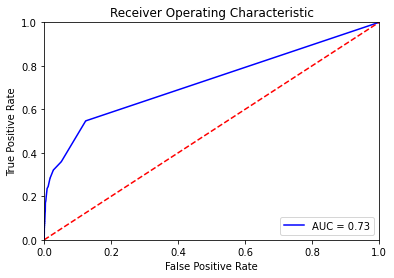

AUC score on train/test split: 0.725254998591946


In [22]:
testModel(RandomForestClassifier(), X, y)

### Multi-layer Perceptron classifier

StandardScaler
[0.82440565 0.87276951 0.84464771 0.82770069 0.82884724 0.8226315
 0.89480948 0.81935675 0.84496772 0.87320164] Average AUC: 0.8453, STD: 0.0249


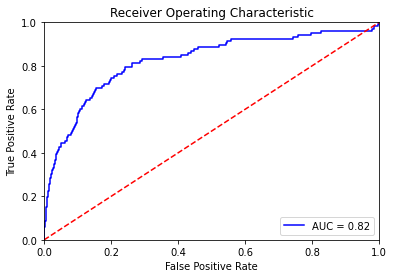

AUC score on train/test split: 0.824430019712757


In [21]:
X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(MLPClassifier(), X_cop, y)

# ---Not as good as StandardScaler!---

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 2 bins')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 4 bins')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 8 bins')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 16 bins')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=32, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 32 bins')
testModel(MLPClassifier(), X_cop, y)

## Conclusions of vanilla models:

| Model      | Kfold AUC Score | Kfold std | Train/test AUC Score | Best Preprocessing |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| Bernoulli Naive Bayes      | 0.7922       | 0.027       | 0.794       | Discretization 32 bins       |
| Gaussian Naive Bayes   | 0.7899       | 0.0291      | 0.790       | Standard Scaler       |
| Multinomial Naive Bayes      | 0.7922       | 0.027      | 0.794      | Discretization 32 bins       |
| Decision Tree   | 0.5285       | 0.0145      | 0.541       | No Preprocessing       |
| Random Forest   | 0.7324        | 0.0543       | 0.725       | No Preprocessing       |
| Multi-layer Perceptron   | 0.8453        | 0.0249       | 0.824       | Standard Scaler      |

We want to find the best parameters for the following models: Multi-layer Perceptron, Multinomial Naive Bayes and Random Forest

## Find best parameters

[0.77756831 0.83318604 0.79389793 0.79189637 0.80920562 0.78641686
 0.86448959 0.79466459 0.82552047 0.79272978] Average AUC: 0.807, STD: 0.0253


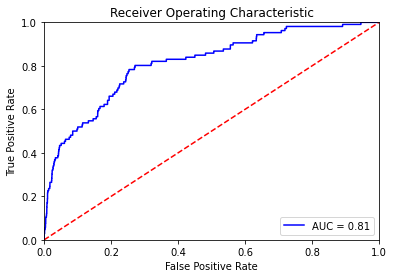

AUC score on train/test split: 0.814136299633906


In [31]:
testModel(RandomForestClassifier(n_estimators=200, max_depth=4), X, y)

[0.81864388 0.88341023 0.85708508 0.82708618 0.8151573  0.83810214
 0.89777403 0.84125909 0.84508356 0.85450141] Average AUC: 0.8478, STD: 0.0253


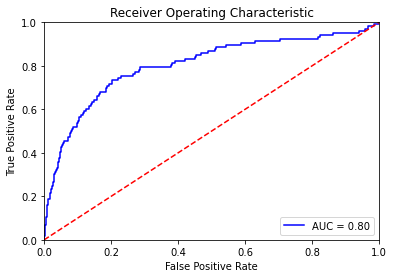

AUC score on train/test split: 0.8034657842861166


In [32]:
params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
testModel(MLPClassifier(**params), X_cop, y)

### Multi-layer Perceptron classifier

Vanilla model
[0.78535875 0.86121441 0.83580706 0.80930869 0.80497966 0.80955606
 0.86793612 0.82188545 0.84688192 0.79037679] Average AUC: 0.8233, STD: 0.0272


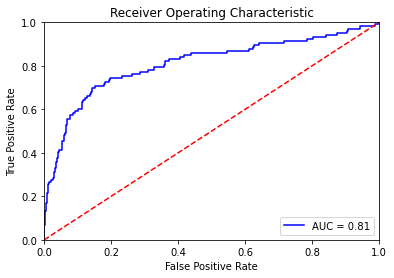

AUC score on train/test split: 0.8098763728527176


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Tuned model with params: {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
[0.79911852 0.8628844  0.84966192 0.81510822 0.80400587 0.79875803
 0.85413231 0.83376329 0.85411268 0.80294178] Average AUC: 0.8274, STD: 0.0248


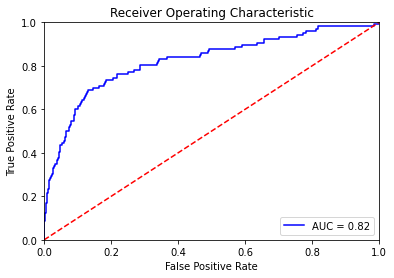

AUC score on train/test split: 0.8226896648831314


In [7]:
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.005],
    'learning_rate': ['adaptive']
}

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
tuneModel(MLPClassifier(), params, X_cop, y)

Multi-layer Perceptron best params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

### Multinomial Naive Bayes classifier

C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Vanilla model
[0.77841479 0.82597522 0.79014218 0.80987706 0.82132003 0.81277093
 0.85808144 0.78279166 0.8466532  0.77351812] Average AUC: 0.81, STD: 0.0274


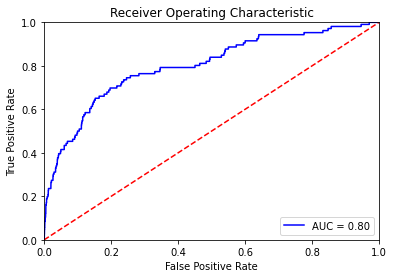

AUC score on train/test split: 0.8005304139678964
Tuned model with params: {'alpha': 0.1}
[0.77899441 0.82732001 0.79124554 0.81057206 0.82140052 0.81268847
 0.85812464 0.78423664 0.84646669 0.77265427] Average AUC: 0.8104, STD: 0.0273


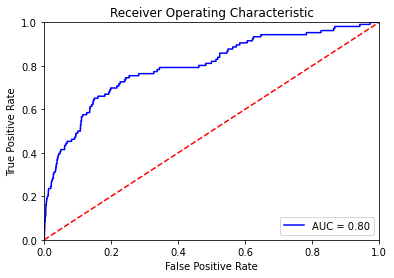

AUC score on train/test split: 0.8000792734441002


In [63]:
params = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
}

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
tuneModel(MultinomialNB(), params, X_cop, y)

Guassian Naive Bayes best params = default

### Random Forest classifier

In [ ]:
params = {
    'n_estimators': [50, 100, 400],
    'class_weight': ['balanced_subsample', None],
    'oob_score': [True],
    'min_samples_split': [2, 4, 6],
    'max_depth': [4, 8, 16],
    'ccp_alpha': [0.0, 0.05]
}

tuneModel(RandomForestClassifier(), params, X, y)

NameError: name 'tuneModel' is not defined